In [95]:
import pandas as pd
import numpy as np
import ast
from tabulate import tabulate

import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [96]:
df = pd.read_csv(r"../output/DEFAULT_FINAL.csv")

In [97]:
# List of metric names
metric_names = ["lift",
    "f1",
    "mse",
    "accuracy",
    "recall",
    "precision",
    "roc_auc",
    "area_under_pr",
    "r2_score",
    "rmse"
]
dataset = df.copy()
# Create columns based on metric names
# Convert string representations to dictionaries
dataset["output_metrics"] = dataset["output_metrics"].apply(ast.literal_eval)
dataset["run_time"] = dataset["run_time"].apply(lambda x: np.round(x/60, 2))
# Create columns based on metric names
for metric in metric_names:
    dataset[metric] = dataset["output_metrics"].apply(
        lambda x: x.get(metric) if isinstance(x, dict) else np.nan
    )
    dataset[f"{metric}_std"] = dataset[metric].apply(
        lambda x: np.std(x) if isinstance(x, list) else np.nan
    )
    dataset[metric] = dataset[metric].apply(
        lambda x: np.average(x) if isinstance(x, list) else np.nan
    )

base_cols   = [
    "dataset",
    "model",
    "run_time",
    "eval_metric",
    "best_score",
    "score_std",
    "output_metrics"]

base_cols += [i for i in metric_names]
base_cols += [i+"_std" for i in metric_names]

dataset = dataset[base_cols]

In [98]:
tomax = {
    "mse": False,
    "rmse": False,
    "accuracy": True,
    "recall": True,
    "precision": True,
    "roc_auc": True,
    "area_under_pr": True,
    "lift": True,
    "f1": True,
    "r2_score": True,
}

# Define a function to select the first row based on whether to maximize or minimize the "best_score"
def select_first_row(group):
    metric = group["eval_metric"].iloc[0]
    ascending = not tomax.get(metric, True)  # If metric not in tomax, assume True (maximize)
    return group.sort_values(by="best_score", ascending=ascending).iloc[0]


# Apply the function to each group
filtered_df = dataset.groupby(["dataset", "model", "eval_metric"]).apply(select_first_row)
# Reset the index to get a new DataFrame
filtered_df = filtered_df.reset_index(drop=True)
# Find the rows that maximize the specified metric for each dataset


# Sort the DataFrame based on whether the metric is to be maximized or not
filtered_df["ascending"] = filtered_df["eval_metric"].map({k:not v for k,v in tomax.items()})  # Create a new column for ascending order
dfmax = filtered_df.loc[filtered_df["ascending"] == False].sort_values(by=["dataset", "eval_metric", "best_score"], ascending=[False, False, False])
dfmin = filtered_df.loc[filtered_df["ascending"] == True].sort_values(by=["dataset", "eval_metric", "best_score"], ascending=[False, False, True])

best_df = pd.concat([dfmax,dfmin])
best_df.drop(columns=["ascending"], inplace=True)

best_df.head(100)

dataset              model  run_time eval_metric  best_score  \
68     titanic           catboost      0.53        lift    2.544501   
76     titanic     tabtransformer      0.67        lift    2.544055   
67     titanic            autoint      0.30        lift    2.513705   
71     titanic            gandalf      0.39        lift    2.513705   
77     titanic                xgb      0.01        lift    2.482910   
73     titanic                mlp      0.01        lift    2.452390   
74     titanic             s1dcnn      0.03        lift    2.267890   
70     titanic      fttransformer      0.82        lift    2.205471   
72     titanic               gate      4.35        lift    2.175122   
69     titanic  categoryembedding      0.26        lift    2.147465   
75     titanic             tabnet      0.72        lift    2.052700   
56        iris            autoint      0.22    accuracy    0.980000   
59        iris      fttransformer      0.52    accuracy    0.980000   
57        iris           catboost      0.09    accuracy    0.960000   
65        iris     tabtransformer      0.38    accuracy    0.960000   
66        iris                xgb      0.02    accuracy    0.960000   
60        iris            gandalf      0.30    accuracy    0.946667   
61        iris               gate      3.03    accuracy    0.913333   
58        iris  categoryembedding      0.26    accuracy    0.906667   
64        iris             tabnet      0.36    accuracy    0.706667   
62        iris                mlp      0.00    accuracy    0.666667   
63        iris             s1dcnn      0.00    accuracy    0.566667   
45     housing           catboost      0.32    r2_score    0.845366   
55     housing                xgb      0.06    r2_score    0.839553   
50     housing                mlp      0.76    r2_score    0.776517   
51     housing             resnet     10.66    r2_score    0.769513   
48     housing            gandalf      2.58    r2_score    0.744356   
46     housing  categoryembedding      2.60    r2_score    0.735457   
49     housing               gate     17.58    r2_score    0.710675   
47     housing      fttransformer      7.21    r2_score    0.706950   
44     housing            autoint      2.10    r2_score    0.695317   
53     housing             tabnet      5.33    r2_score    0.684892   
54     housing     tabtransformer      0.97    r2_score    0.591981   
52     housing             s1dcnn      0.10    r2_score   -3.465647   
33       heloc           catboost      0.45     roc_auc    0.798043   
35       heloc      fttransformer      7.06     roc_auc    0.794686   
36       heloc            gandalf      0.86     roc_auc    0.792947   
37       heloc               gate      4.78     roc_auc    0.792429   
43       heloc                xgb      0.04     roc_auc    0.789717   
38       heloc                mlp      0.06     roc_auc    0.787371   
34       heloc  categoryembedding      0.62     roc_auc    0.785944   
41       heloc             tabnet      2.00     roc_auc    0.784166   
32       heloc            autoint      0.89     roc_auc    0.781117   
39       heloc             resnet      3.65     roc_auc    0.780776   
42       heloc     tabtransformer      0.62     roc_auc    0.779706   
40       heloc             s1dcnn      0.05     roc_auc    0.753528   
31    diabetes                xgb      5.92        lift    2.471118   
21    diabetes           catboost      5.89        lift    2.453507   
25    diabetes               gate     20.78        lift    2.442931   
28    diabetes             s1dcnn      0.60        lift    2.296753   
24    diabetes            gandalf      4.92        lift    2.281752   
26    diabetes                mlp      0.97        lift    2.267699   
30    diabetes     tabtransformer     39.93        lift    2.244793   
27    diabetes             resnet     61.35        lift    2.226304   
23    diabetes      fttransformer     38.83        lift    2.108253   
29    diabetes             tabn

In [99]:
best_df.columns

Index(['dataset', 'model', 'run_time', 'eval_metric', 'best_score',
       'score_std', 'output_metrics', 'lift', 'f1', 'mse', 'accuracy',
       'recall', 'precision', 'roc_auc', 'area_under_pr', 'r2_score', 'rmse',
       'lift_std', 'f1_std', 'mse_std', 'accuracy_std', 'recall_std',
       'precision_std', 'roc_auc_std', 'area_under_pr_std', 'r2_score_std',
       'rmse_std'],
      dtype='object')

# Housing


In [100]:
# Convert DataFrame to ASCII table
def make_results_table(df, dataset_name, display_cols, metric_cols, image_name, dpi = 1200):
    result_df = df.loc[df['dataset'] ==  dataset_name].reset_index(drop = True).copy()

    # Create a dictionary to store the indices of the rows with the highest values for each metric column
    max_indices = {}
    for metric in metric_cols:
        max_indices[metric] = result_df[metric].idxmax()
    
            
    # Modify all columns with std to include relative std
    result_df['best_score'] = result_df.apply(
            lambda row: f"{row['best_score']:.3f} ± ({row['score_std']:.3f})", axis=1
        )
    for metric in metric_cols:
        result_df[metric] = result_df.apply(
            lambda row: f"{row[metric]:.3f} ± ({row[metric+'_std']:.3f})", axis=1
        )
        # Drop the corresponding std column
        result_df.drop(columns=[metric + '_std'], inplace=True)


    # Apply underlining to the rows with the highest values for each metric column
    # for metric, max_index in max_indices.items():
        
        #result_df.at[max_index, metric] = '\033[1;4m' + result_df.at[max_index, metric] + '\033[0m'
    
    #print(result_df)
    
    ascii_table = tabulate(result_df[display_cols], headers='keys', tablefmt='fancy_grid')
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Hide the axis
    ax.axis('off')
    
    # Display the ASCII table as text
    ax.text(0.1, 0.1, ascii_table, fontsize=10, family='monospace')
    
    # Save the plot as an image file (e.g., PNG)
    plt.savefig(f'./images/{image_name}.png', bbox_inches='tight', dpi=dpi, pad_inches=0.1)
    
    # Show the plot (optional)
    plt.show()

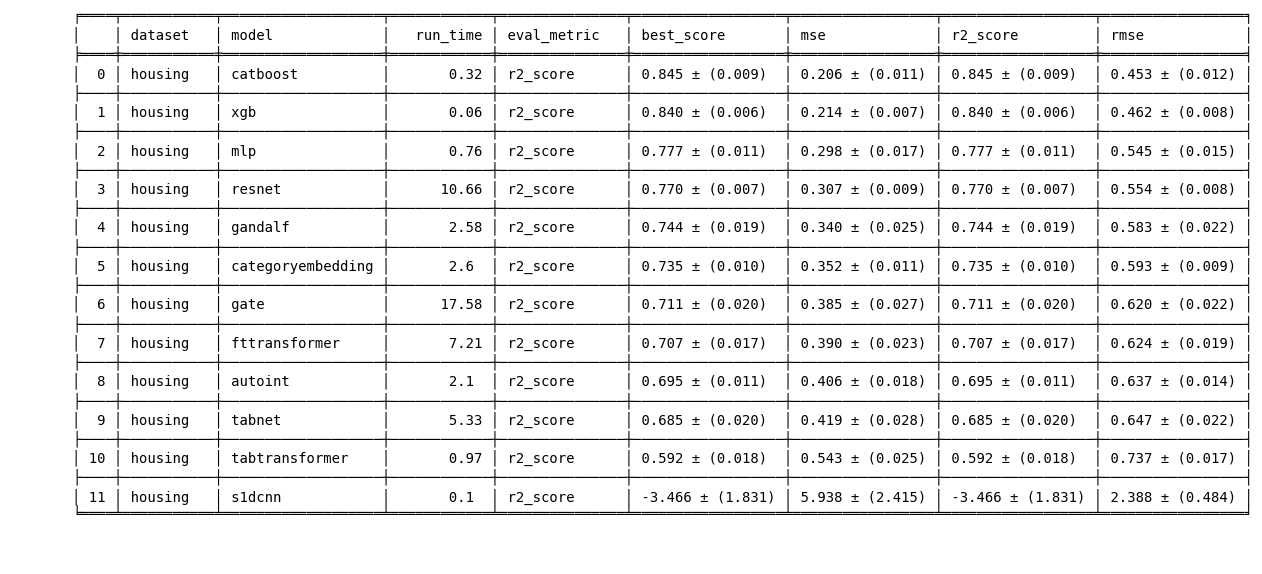

In [101]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'mse','r2_score','rmse']
metric_cols = ['mse','r2_score','rmse']
dataset_name = "housing"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

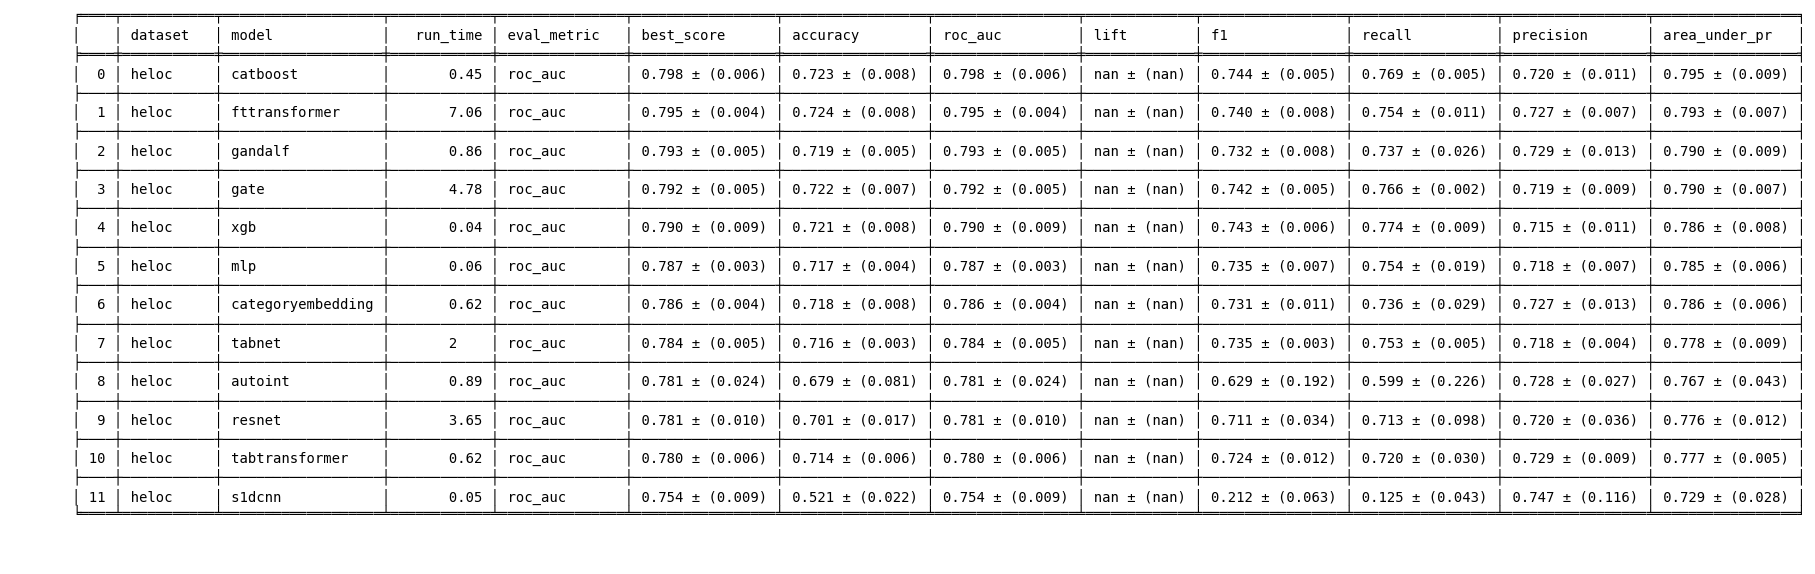

In [102]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "heloc"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

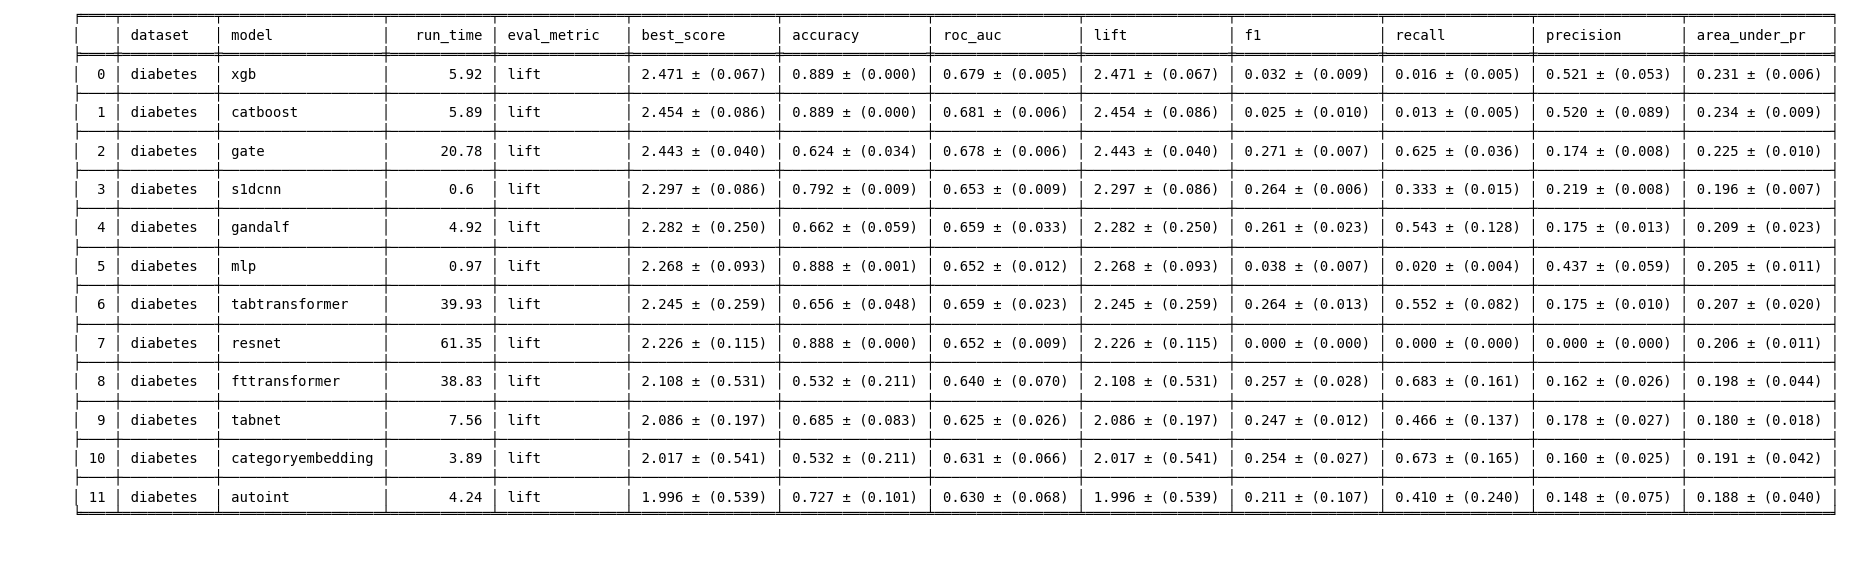

In [103]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "diabetes"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

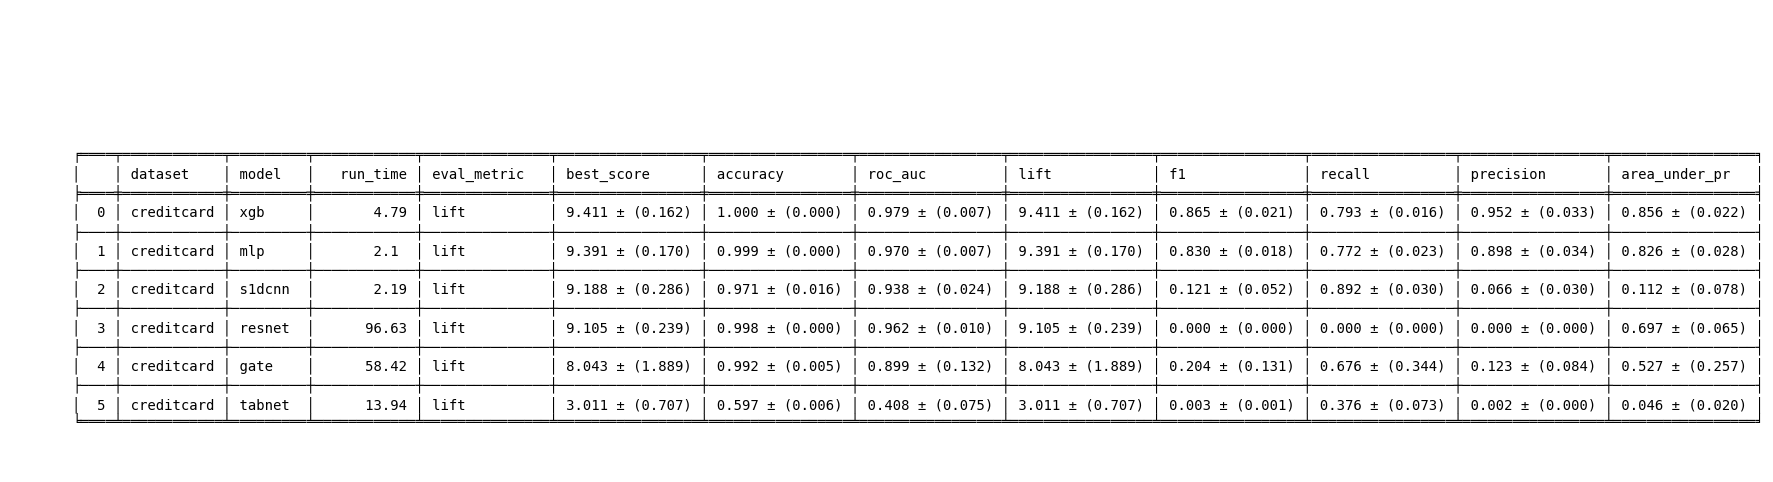

In [104]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "creditcard"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

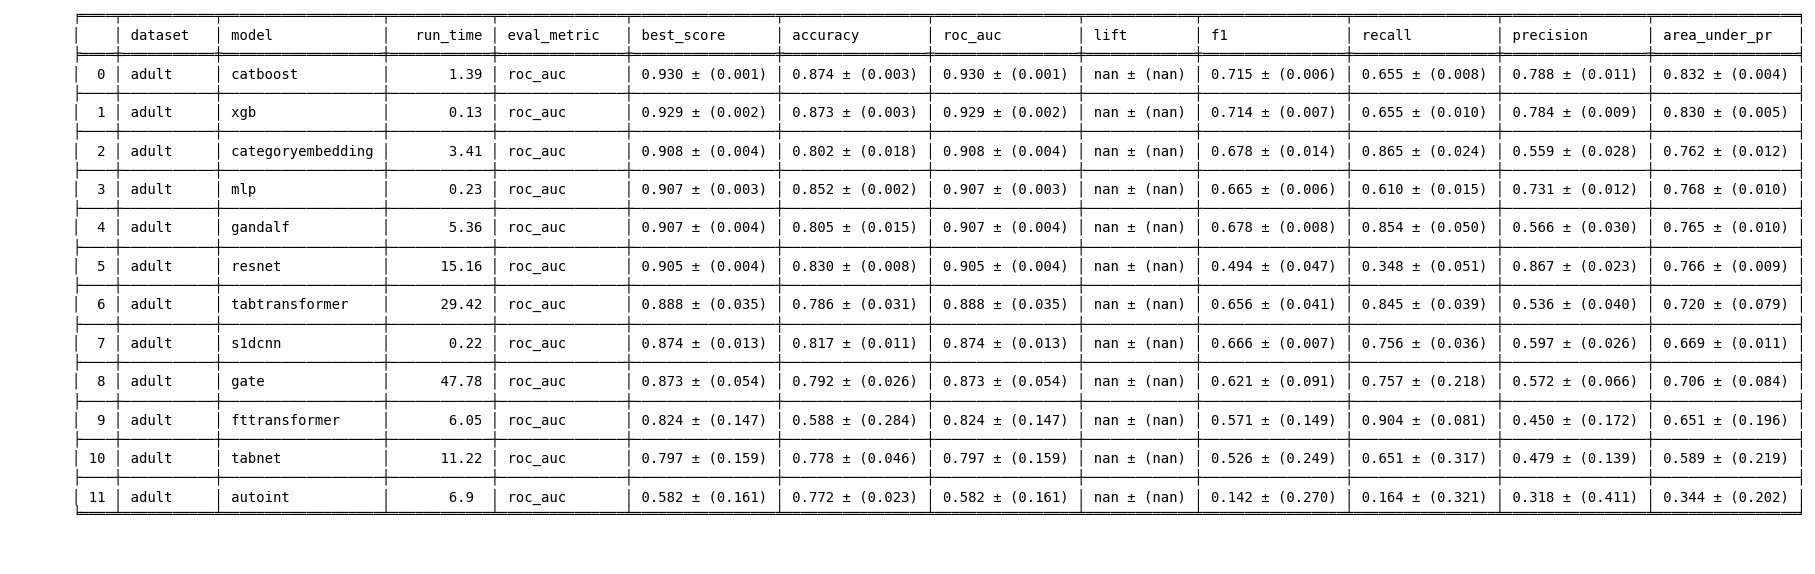

In [105]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "adult"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

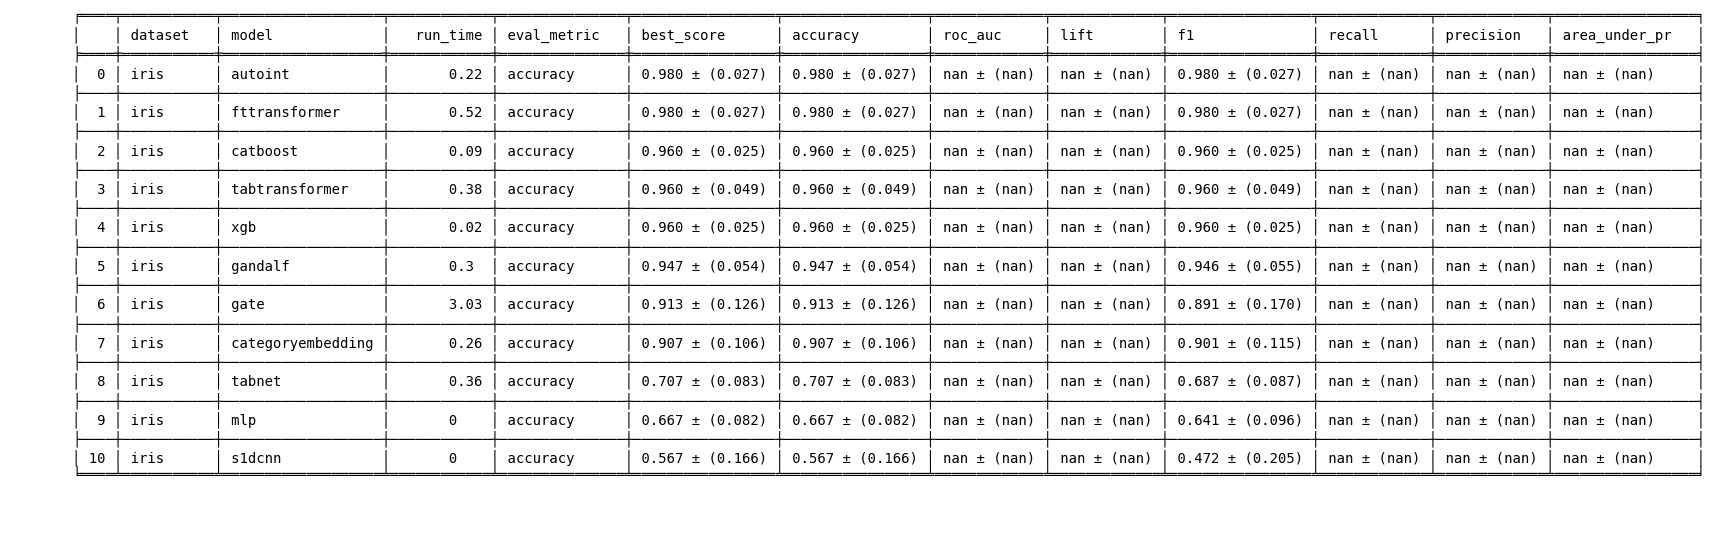

In [107]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "iris"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

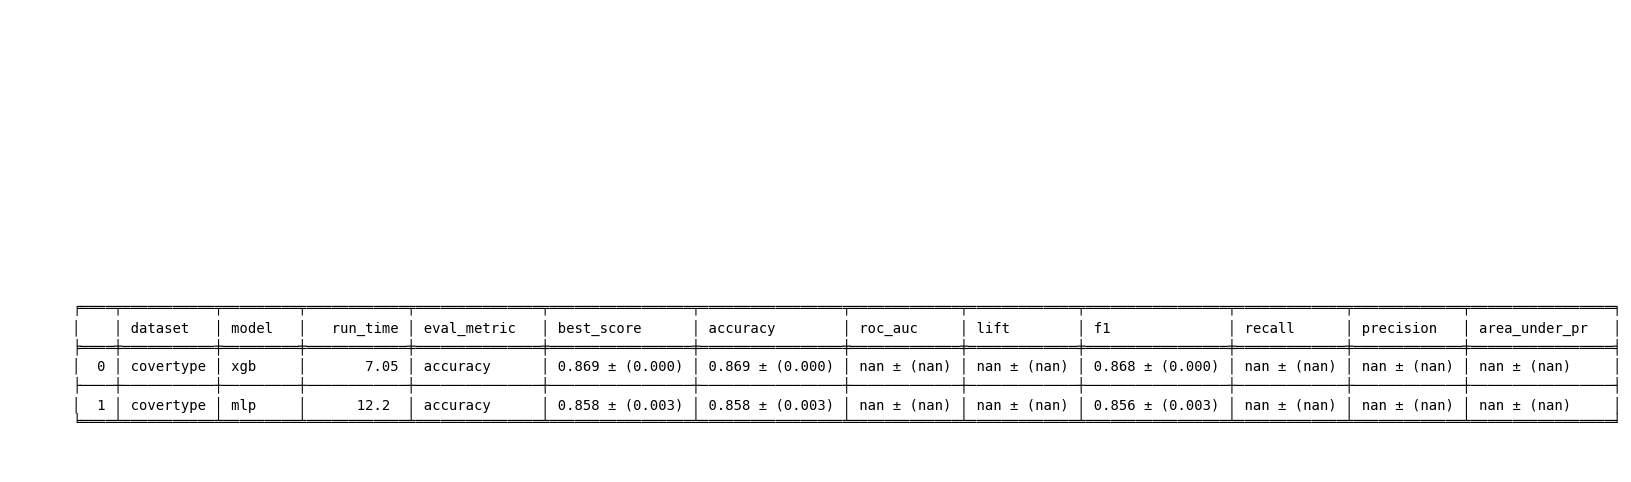

In [108]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "covertype"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

In [109]:
df = pd.read_csv(r"/home/boom/sdev/WTabRun/data/kaggle/icr-identify-age-related-conditions/test.csv")
df2 = df = pd.read_csv(r"/home/boom/sdev/WTabRun/data/kaggle/icr-identify-age-related-conditions/train.csv")

In [110]:
dft = pd.concat([df,df2])

In [113]:
dft

Id        AB           AF           AH          AM          AR  \
0    000ff2bfdfe9  0.209377   3109.03329    85.200147   22.394407    8.138688   
1    007255e47698  0.145282    978.76416    85.200147   36.968889    8.138688   
2    013f2bd269f5  0.470030   2635.10654    85.200147   32.360553    8.138688   
3    043ac50845d5  0.252107   3819.65177   120.201618   77.112203    8.138688   
4    044fb8a146ec  0.380297   3733.04844    85.200147   14.103738    8.138688   
5    04517a3c90bd  0.209377   2615.81430    85.200147    8.541526    8.138688   
6    049232ca8356  0.348249   1733.65412    85.200147    8.377385   15.312480   
7    057287f2da6d  0.269199    966.45483    85.200147   21.174189    8.138688   
8    0594b00fb30a  0.346113   3238.43674    85.200147   28.888816    8.138688   
9    05f2bc0155cd  0.324748   5188.68207    85.200147   12.968687    8.138688   
10   06055f3f6785  0.504214   6089.31532    85.200147  189.781063   17.027268   
11   06554e7b9979  0.760594   6957.75289   200.089275   23.462872    8.138688   
12   068a4e4bbbab  0.491395   2627.29962   138.377301   48.969764    8.138688   
13   06c0ddf265c5  0.534125   4784.80222    90.704235    8.739734    8.138688   
14   075bd937ab85  0.508487   1632.12907    85.200147   11.864607   17.617218   
15   07760b4cf3f8  0.666588   3657.78160   304.283751   75.418144    8.138688   
16   094c0bd5ebe6  0.252107   5180.17214    85.200147   14.438214    8.138688   
17   0aa059dad7f3  0.448665   3516.61453   109.454712   56.644130    8.138688   
18   0b2cc0b0e6c5  0.269199   1586.67784    85.200147   14.459893    8.138688   
19   0c3a256bcec7  0.132463   2160.54454    85.200147   20.300835    8.138688   
20   0cdf781c81b9  0.555490   6232.74146    85.200147   25.739167    8.138688   
21   0ce8b2aeeead  0.546944   1473.30689   140.990001   74.699640    8.138688   
22   0cf19653f4c5  0.247834   5392.91555    85.200147    8.749025    8.138688   
23   0cf6c827b8bb  0.371751   2354.54142   105.030540    5.150311    8.138688   
24   0d1b855c7635  0.158101   3257.64549   138.368592    8.640630   18.385464   
25   0d733722754b  0.235015   3081.43198    85.200147    8.739734    8.138688   
26   0da59360d722  1.448547   2956.78262   130.112460   42.416512    8.138688   
27   0db07bc343e3  0.273472   2310.59664    85.200147   13.217996    8.138688   
28   0e17c8abe9b6  0.121780   4306.18430    85.200147   11.325729    8.138688   
29   0e1f6a8eebab  1.324630   1478.59338    85.200147   61.407316   17.703744   
30   0e705a0eddf6  0.495668   2405.16782    85.200147   60.190195    8.138688   
31   0e798fd4e6e7  0.743502   3447.90831    85.200147   79.431856    8.138688   
32   0f5fba133cb7  0.461484   4253.98732    85.200147   70.627085    8.138688   
33   0f9257f237b4  0.162374   3245.45474    85.200147   14.469184    8.138688   
34   0fa0daef7ac0  0.444392   4230.15032   112.694460  126.704464    8.138688   
35   10187958312d  0.316202   2255.38192    85.200147   13.750680    8.138688   
36   103f611fdfc4  0.273472   3820.06196    85.200147    8.131173    8.138688   
37   1073082e7823  0.226469   2386.38862    85.200147    8.937942    9.706644   
38   10aaf6adb652  0.397389   2451.22889   104.986995   67.852173    8.138688   
39   10b874d01acd  0.119644   3380.98442    85.200147    4.270763    8.138688   
40   1106df45b12e  0.200831   2043.07774    85.200147    7.767276    8.138688   
41   1136a2966ed2  0.726410   7720.75106    85.200147   32.595925    8.138688   
42   124cd364aa2e  0.324748   1696.64506    85.200147   14.661198    8.138688   
43   124eefa2ae00  0.794778   1831.11720    85.200147   15.680111    8.138688   
44   128cc82dc5d6  0.264926   2055.27938   130.896270   26.922221    8.138688   
45   12d002d52230  1.491277   2434.32640   137.149332  124.242349    8.138688   
46   1319c3883fff  0.243561   3316.81570    85.200147   13.406913    8.138688   
47   1337ba12ff02  0.271336   1977.10370    85.200147   21.096764    8.138688   
48   135f1d1da85e  0.820416   3594.95356   134

In [114]:
dft.to_csv(r"/home/boom/sdev/WTabRun/data/kaggle/icr-identify-age-related-conditions/trainX.csv")